In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget
!pip install mdatagen
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget
!pip install numpy scipy sklearn
!pip install jax
!pip install chex
!pip install attr
!pip install optax



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd


from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SinkhornImputation import SinkhornImputation
from Sinkhorn_CMI import *
from RR_imputer import RRimputer
import matplotlib.pyplot as plt
from CMI import *

from Inject_Missing_Values import *

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")
import pandas as pd

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


**Load Data**

In [3]:
import pandas as pd

# Read CSV file into a Pandas DataFrame
groundTruth = pd.read_csv(r'Data\Diabetic_Ground_Truth.csv', delimiter=',', header=0)

# Store feature columns in a DataFrame


X= groundTruth.iloc[:, :-1]  # Selects all rows and all columns except the last one
Y = groundTruth.iloc[:, -1]  # Selects all rows and only the last column


In [4]:
print(groundTruth.shape)
groundTruth_tensor = torch.tensor(scale(groundTruth)) #converting groundTruth to Tensor, z-score scaling

(905, 18)


In [5]:
print(groundTruth_tensor.min())
print(groundTruth_tensor.max())
print(groundTruth_tensor.mean())
print(groundTruth_tensor.median())

tensor(-2.9665)
tensor(7.9776)
tensor(1.8320e-17)
tensor(-0.3642)


In [6]:
bucket_specs = {
     
    0: 4,   #  age (4 bins)
    1: 2,  #  sex (2 bins)
    17: 2,  # Column 21 → label  (2 bins)
    2: 2,   # Column 5 → savings-account (5 bins)
    3: 2,   # Column 15 → jobs (4 bins)
    5: 5,
    13: 3
}

# Define multiple attributes for X, Y, Z
X_cols = [0,1]  # Bucketized sensitive attributes (e.g., sex, race, age)
Y_cols = [17]     # Bucketized outcome-related attributes
Z_cols = [2, 3,5,13]  

**CMI for GroundTruth**

In [7]:
cmi_groundTruth = CMI.conditional_mutual_information(groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
print(cmi_groundTruth)

0.29797133803367615


MCAR 30%

In [8]:
generator = Inject_Missing_Values()
miss_mcar30,index_mcar30 = generator.MCAR(X,missing_rate=30)
type(miss_mcar30)
miss_mcar30 = pd.concat([miss_mcar30, Y], axis=1) #adding the target coloumn

In [9]:
miss_mcar30_numpy = scale(miss_mcar30) #z-score scaling
miss_mcar30_tensor = torch.tensor(miss_mcar30_numpy) #converting to tensor

In [10]:
#only Sinkhorn
n_mcar30, d_mcar30 = miss_mcar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(miss_mcar30_tensor)
print(epsilon_mcar30)
mask_mcar30= torch.isnan(miss_mcar30_tensor).double()


on_sk_imputer_mcar30 = SinkhornImputation(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
on_sk_imp_mcar30, on_sk_maes30mcar, on_sk_rmses30mcar = on_sk_imputer_mcar30.fit_transform(miss_mcar30_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mcar30_numpy = on_sk_imp_mcar30.detach().cpu().numpy()
on_sk_mae_mcar30 = MAE(on_sk_imp_mcar30,groundTruth_tensor , mask_mcar30)
on_sk_rmse_mcar30 = RMSE(on_sk_imp_mcar30, groundTruth_tensor, mask_mcar30)
print(on_sk_mae_mcar30,on_sk_rmse_mcar30)

0.5863885804484416


INFO:root:batchsize = 128, epsilon = 0.5864
INFO:root:Iteration 0:	 Loss: 4.9047	 Validation MAE: 0.7864	RMSE: 0.9783
INFO:root:Iteration 50:	 Loss: 3.3578	 Validation MAE: 0.6482	RMSE: 0.9065
INFO:root:Iteration 100:	 Loss: 3.8040	 Validation MAE: 0.6084	RMSE: 0.8815
INFO:root:Iteration 150:	 Loss: 2.9688	 Validation MAE: 0.5842	RMSE: 0.8638
INFO:root:Iteration 200:	 Loss: 3.5821	 Validation MAE: 0.5684	RMSE: 0.8517
INFO:root:Iteration 250:	 Loss: 3.2436	 Validation MAE: 0.5566	RMSE: 0.8403
INFO:root:Iteration 300:	 Loss: 3.1156	 Validation MAE: 0.5495	RMSE: 0.8339
INFO:root:Iteration 350:	 Loss: 3.1122	 Validation MAE: 0.5416	RMSE: 0.8269
INFO:root:Iteration 400:	 Loss: 3.1382	 Validation MAE: 0.5345	RMSE: 0.8205
INFO:root:Iteration 450:	 Loss: 3.3947	 Validation MAE: 0.5283	RMSE: 0.8142
INFO:root:Iteration 500:	 Loss: 3.4720	 Validation MAE: 0.5232	RMSE: 0.8092
INFO:root:Iteration 550:	 Loss: 3.7386	 Validation MAE: 0.5195	RMSE: 0.8049
INFO:root:Iteration 600:	 Loss: 3.2812	 Validat

tensor(0.4960, grad_fn=<DivBackward0>) tensor(0.7812, grad_fn=<SqrtBackward0>)


CMI only for Sinkhorn Imputation

In [11]:
#only CMI
on_cmi_missmcar30 = CMI.conditional_mutual_information(on_sk_imp_mcar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(on_cmi_missmcar30)
print(on_sk_mae_mcar30,on_sk_rmse_mcar30)

0.31806379556655884
tensor(0.4960, grad_fn=<DivBackward0>) tensor(0.7812, grad_fn=<SqrtBackward0>)


In [12]:
#sinkhorn_CMI
n_mcar30, d_mcar30 = miss_mcar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(miss_mcar30_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mcar30)
mask_mcar30= torch.isnan(miss_mcar30_tensor).double()


sk_imputer_mcar30 = SinkhornImputation_CMI(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar,cmi_loss = sk_imputer_mcar30.fit_transform(miss_mcar30_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30,groundTruth_tensor , mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30, groundTruth_tensor, mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)





0.5863885804484416


INFO:root:Iteration 0:	 Loss: 3.8014	 Validation MAE: 0.7875	RMSE: 0.9784
INFO:root:Iteration 50:	 Loss: 3.4767	 Validation MAE: 0.6445	RMSE: 0.9034
INFO:root:Iteration 100:	 Loss: 3.6201	 Validation MAE: 0.6039	RMSE: 0.8766
INFO:root:Iteration 150:	 Loss: 3.7252	 Validation MAE: 0.5783	RMSE: 0.8583
INFO:root:Iteration 200:	 Loss: 3.7502	 Validation MAE: 0.5634	RMSE: 0.8464
INFO:root:Iteration 250:	 Loss: 4.0923	 Validation MAE: 0.5516	RMSE: 0.8357
INFO:root:Iteration 300:	 Loss: 4.2362	 Validation MAE: 0.5445	RMSE: 0.8293
INFO:root:Iteration 350:	 Loss: 3.9573	 Validation MAE: 0.5355	RMSE: 0.8229
INFO:root:Iteration 400:	 Loss: 4.4149	 Validation MAE: 0.5294	RMSE: 0.8174
INFO:root:Iteration 450:	 Loss: 4.4552	 Validation MAE: 0.5248	RMSE: 0.8125
INFO:root:Iteration 500:	 Loss: 4.5504	 Validation MAE: 0.5202	RMSE: 0.8063
INFO:root:Iteration 550:	 Loss: 4.2626	 Validation MAE: 0.5172	RMSE: 0.8034
INFO:root:Iteration 600:	 Loss: 5.5360	 Validation MAE: 0.5145	RMSE: 0.8008
INFO:root:Itera

tensor(0.4893, grad_fn=<DivBackward0>) tensor(0.7717, grad_fn=<SqrtBackward0>)


CMI for Sinkhorn_CMI Imputation

In [13]:
#CMI
cmi_mcar30 = CMI.conditional_mutual_information(sk_imp_mcar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(cmi_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

0.29282113909721375
tensor(0.4893, grad_fn=<DivBackward0>) tensor(0.7717, grad_fn=<SqrtBackward0>)


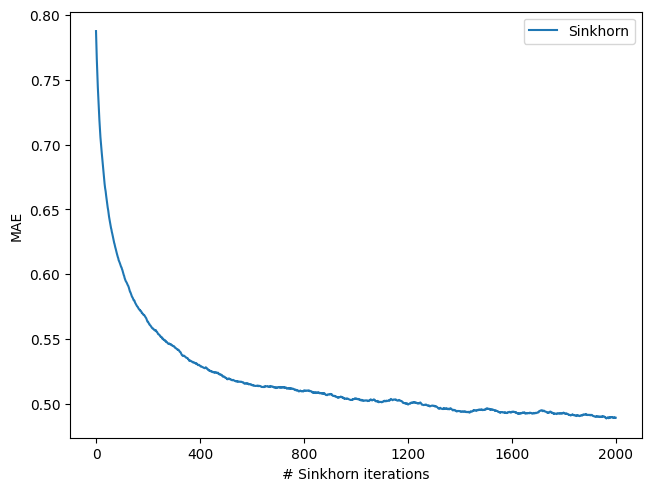

In [14]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes30mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes30mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')
ax.set_ylabel('MAE')
plt.legend()
plt.show()

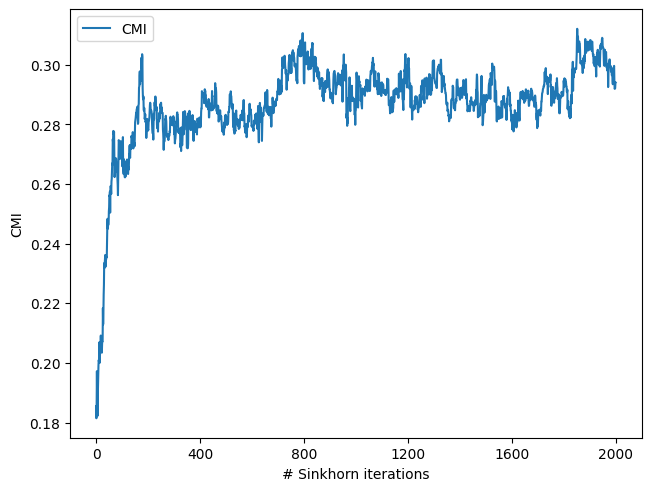

In [15]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(cmi_loss)

ax.plot(np.linspace(0, 1, npoints) * npoints, cmi_loss, label='CMI')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.set_ylabel('CMI')
plt.legend()
plt.show()

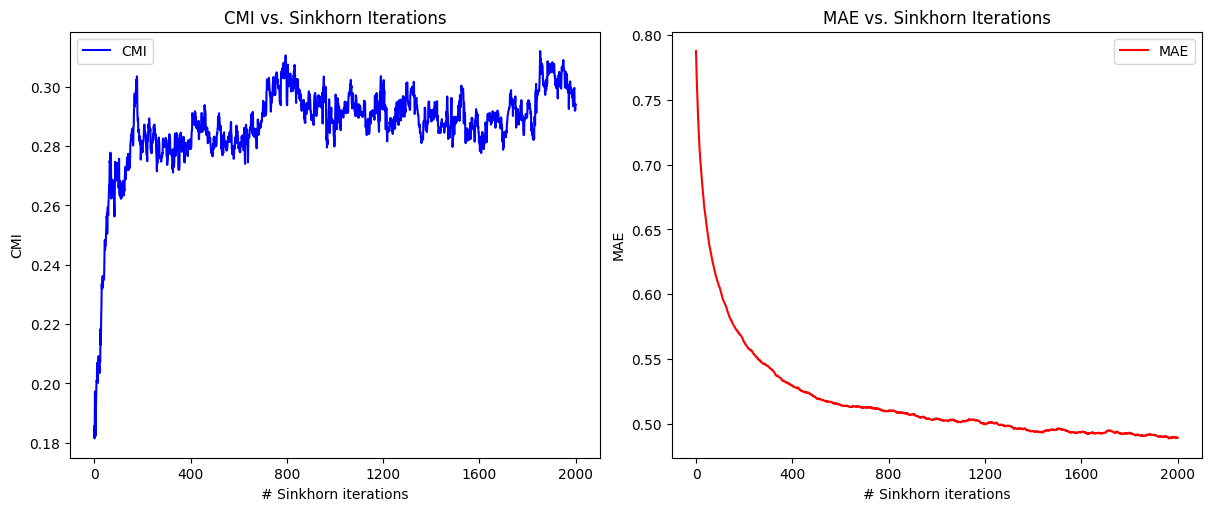

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (Replace with actual values)
npoints_cmi = len(cmi_loss)  # Length of CMI data
npoints_mae = len(sk_maes30mcar)  # Length of MAE data

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# First graph (CMI)
axes[0].plot(np.linspace(0, 1, npoints_cmi) * npoints_cmi, cmi_loss, label='CMI', color='b')
axes[0].set_xticks(np.linspace(0, npoints_cmi, 6))
axes[0].set_xlabel('# Sinkhorn iterations')
axes[0].set_ylabel('CMI')
axes[0].legend()
axes[0].set_title('CMI vs. Sinkhorn Iterations')

# Second graph (MAE)
axes[1].plot(np.linspace(0, 1, npoints_mae) * npoints_mae, sk_maes30mcar, label='MAE', color='r')
axes[1].set_xticks(np.linspace(0, npoints_mae, 6))
axes[1].set_xlabel('# Sinkhorn iterations')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_title('MAE vs. Sinkhorn Iterations')

# Show the combined plot
plt.show()


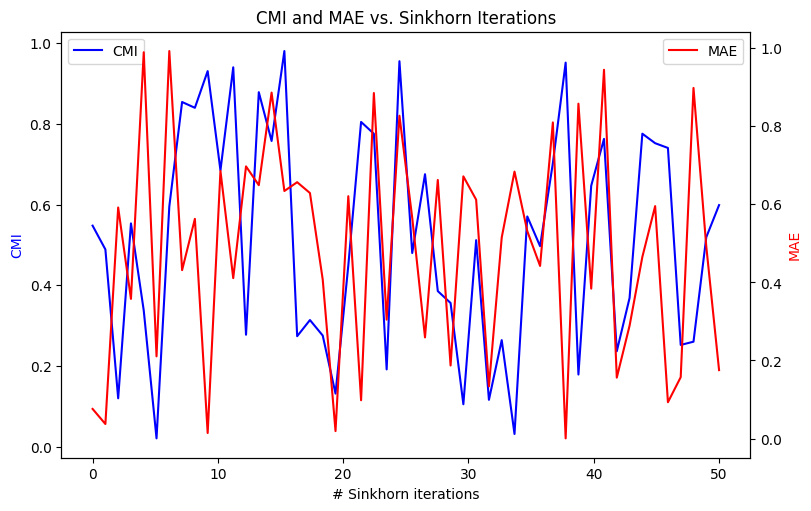

In [17]:
# Re-import necessary libraries after execution state reset
import matplotlib.pyplot as plt
import numpy as np

# Sample data (Replace with actual values)
cmi_loss = np.random.rand(50)  # Example data for CMI
sk_maes30mcar = np.random.rand(50)  # Example data for MAE

npoints = max(len(cmi_loss), len(sk_maes30mcar))  # Use the max length to align both plots

# Create figure
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)

# Plot CMI (left y-axis)
ax.plot(np.linspace(0, 1, len(cmi_loss)) * len(cmi_loss), cmi_loss, label='CMI', color='b')

# Create second y-axis for MAE
ax2 = ax.twinx()
ax2.plot(np.linspace(0, 1, len(sk_maes30mcar)) * len(sk_maes30mcar), sk_maes30mcar, label='MAE', color='r')

# Formatting axes
ax.set_xlabel('# Sinkhorn iterations')
ax.set_ylabel('CMI', color='b')
ax2.set_ylabel('MAE', color='r')

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.title("CMI and MAE vs. Sinkhorn Iterations")
plt.show()


In [18]:
# Find the best trade-off index using the heuristic
best_tradeoff_idx = np.argmin(sk_maes30mcar + cmi_loss)

# Get the corresponding values
best_cmi = cmi_loss[best_tradeoff_idx]
best_mae = sk_maes30mcar[best_tradeoff_idx]

# Display the best trade-off values
best_tradeoff_idx, best_cmi, best_mae


(np.int64(19),
 np.float64(0.1313794903498341),
 np.float64(0.019189022016329216))

**30% MAR**

In [19]:
dependencies_mar30 = {"savings-account": {
        "influencers": ["age"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.2 if row["age"]<=25 else 0.1 
    },
    "checking-account": {
        "influencers": ["age"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.2 if row["age"]<=25 else 0.1 
    },
    "credit-amount": {
        "influencers": ["age"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.2 if row["age"]<=25 else 0.1 
    },
    "employment-since": {
        "influencers": ["sex"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.2 if row["sex"]==1 else 0.1 
    },
    "duration": {
        "influencers": ["sex"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.2 if row["sex"]==1 else 0.1
    }
}

In [20]:
generator_mar30 = Inject_Missing_Values()
miss_mar30,index_mar30 = generator_mar30.MAR(X,dependencies_mar30,missing_rate=30)
miss_mar30 = pd.concat([miss_mar30, Y], axis=1) #adding the target coloumn

total_missing_percentage_mar30= miss_mar30.isnull().sum().sum() / miss_mar30.size * 100
print(f"Total Missing Percentage MAR30: {total_missing_percentage_mar30:.2f}%")

KeyError: 'age'

In [ ]:
miss_mar30_numpy = scale(miss_mar30)#z-score scaling
miss_mar30_tensor = torch.tensor(miss_mar30_numpy) #converting to tensor

In [ ]:
missing_percentage = (miss_mar30.isnull().sum() / len(miss_mar30)) * 100
print(missing_percentage)

checking-account                         80.0
duration                                 80.0
credit-history                            0.0
purpose                                   0.0
credit-amount                            80.0
savings-account                          80.0
employment-since                         80.0
installment-rate                          0.0
other-debtors                             0.0
residence-since                           0.0
property                                  0.0
age                                       0.0
other-installment                         0.0
housing                                   0.0
existing-credits                          0.0
job                                       0.0
number-people-provide-maintenance-for     0.0
telephone                                 0.0
foreign-worker                            0.0
sex                                       0.0
marital-status                            0.0
class-label                       

In [ ]:
#only Sinkhorn
n_mar30, d_mar30 = miss_mar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar30 = pick_epsilon(miss_mar30_tensor)
print(epsilon_mar30)
mask_mar30= torch.isnan(miss_mar30_tensor).double()


on_sk_imputer_mar30 = SinkhornImputation(eps=epsilon_mar30, batchsize=batchsize, lr=lr, niter=2000)
on_sk_imp_mar30, on_sk_maes30mar, on_sk_rmses30mar = on_sk_imputer_mar30.fit_transform(miss_mar30_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mar30_numpy = on_sk_imp_mar30.detach().cpu().numpy()
on_sk_mae_mar30 = MAE(on_sk_imp_mar30,groundTruth_tensor , mask_mar30)
on_sk_rmse_mar30 = RMSE(on_sk_imp_mar30, groundTruth_tensor, mask_mar30)
print(on_sk_mae_mar30,on_sk_rmse_mar30)

INFO:root:batchsize = 128, epsilon = 0.8427


0.8427276939532018


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
#only CMI
on_cmi_missmar30 = CMI.conditional_mutual_information(on_sk_imp_mar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(on_cmi_missmar30)
print(on_sk_mae_mar30,on_sk_rmse_mar30)

NameError: name 'on_sk_imp_mar30' is not defined

In [ ]:
#sinkhorn_CMI
n_mar30, d_mar30 = miss_mar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar30 = pick_epsilon(miss_mar30_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mar30)
mask_mar30= torch.isnan(miss_mar30_tensor).double()


sk_imputer_mar30 = SinkhornImputation_CMI(eps=epsilon_mar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mar30, sk_maes30mar, sk_rmses30mar,cmi_loss_mar30 = sk_imputer_mar30.fit_transform(miss_mar30_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mar30_numpy = sk_imp_mar30.detach().cpu().numpy()

sk_mae_mar30 = MAE(sk_imp_mar30,groundTruth_tensor , mask_mar30)
sk_rmse_mar30 = RMSE(sk_imp_mar30, groundTruth_tensor, mask_mar30)
print(sk_mae_mar30,sk_rmse_mar30)


In [ ]:
#CMI
cmi_mar30 = CMI.conditional_mutual_information(sk_imp_mar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(cmi_mar30)
print(sk_mae_mar30,sk_rmse_mar30)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (Replace with actual values)
npoints_cmi = len(cmi_loss_mar30)  # Length of CMI data
npoints_mae = len(sk_maes30mar)  # Length of MAE data

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# First graph (CMI)
axes[0].plot(np.linspace(0, 1, npoints_cmi) * npoints_cmi, cmi_loss_mar30, label='CMI', color='b')
axes[0].set_xticks(np.linspace(0, npoints_cmi, 6))
axes[0].set_xlabel('# Sinkhorn iterations')
axes[0].set_ylabel('CMI')
axes[0].legend()
axes[0].set_title('CMI vs. Sinkhorn Iterations')

# Second graph (MAE)
axes[1].plot(np.linspace(0, 1, npoints_mae) * npoints_mae, sk_maes30mar, label='MAE', color='r')
axes[1].set_xticks(np.linspace(0, npoints_mae, 6))
axes[1].set_xlabel('# Sinkhorn iterations')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_title('MAE vs. Sinkhorn Iterations')

# Show the combined plot
plt.show()


**30% MNAR**

In [ ]:
dependencies_mnar30 = {
    "checking-account": {
        "influencers": ["checking-account"],
         "condition": lambda row: True,
        "probability": lambda row: 0.25 if row["checking-account"] == 0 else 0.05
    },
    "duration": {
        "influencers": ["duration"],
        "condition": lambda row: True,
        "probability": lambda row: 0.25 if row["duration"] <= 20 else 0.05
    },
    "savings-account": {
        "influencers": ["savings-account"],
        "condition": lambda row: True,
        "probability": lambda row: 0.2 if row["savings-account"] != 0 else 0.1
    },
    "employment-since": {
        "influencers": ["employment-since"],
         "condition": lambda row: True,
        "probability": lambda row: 0.2 if row["employment-since"] in [1,2] else 0.1
    },
    "credit-amount": {
        "influencers": ["credit-amount"],
         "condition": lambda row: True,
        "probability": lambda row: 0.25 if row["credit-amount"] > 5000 else 0.05
    }
}

In [ ]:
generator_mnar30 = Inject_Missing_Values()
miss_mnar30,index_mnar30 = generator_mnar30.MNAR(X,dependencies_mnar30,missing_rate=30)

miss_mnar30 = pd.concat([miss_mnar30, Y], axis=1) #adding the target coloumn

total_missing_percentage_mnar30= miss_mnar30.isnull().sum().sum() / miss_mnar30.size * 100
print(f"Total Missing Percentage MNAR30: {total_missing_percentage_mnar30:.2f}%")

Total Missing Percentage MNAR30: 18.18%


In [ ]:
miss_mnar30_numpy = scale(miss_mnar30) #z-score scaling
miss_mnar30_tensor = torch.tensor(miss_mnar30_numpy) #converting to tensor

In [ ]:
#only Sinkhorn
n_mnar30, d_mnar30 = miss_mnar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar30 = pick_epsilon(miss_mnar30_tensor)
print(epsilon_mnar30)
mask_mnar30= torch.isnan(miss_mnar30_tensor).double()


on_sk_imputer_mnar30 = SinkhornImputation(eps=epsilon_mnar30, batchsize=batchsize, lr=lr, niter=2000)
on_sk_imp_mnar30, on_sk_maes30mnar, on_sk_rmses30mnar = on_sk_imputer_mnar30.fit_transform(miss_mnar30_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mnar30_numpy = on_sk_imp_mnar30.detach().cpu().numpy()
on_sk_mae_mnar30 = MAE(on_sk_imp_mnar30,groundTruth_tensor , mask_mnar30)
on_sk_rmse_mnar30 = RMSE(on_sk_imp_mnar30, groundTruth_tensor, mask_mnar30)
print(on_sk_mae_mnar30,on_sk_rmse_mnar30)

INFO:root:batchsize = 128, epsilon = 0.8433
INFO:root:Iteration 0:	 Loss: 5.0974	 Validation MAE: 0.7746	RMSE: 0.9693


0.8432825084663274


INFO:root:Iteration 50:	 Loss: 5.3693	 Validation MAE: 0.7501	RMSE: 0.9500
INFO:root:Iteration 100:	 Loss: 5.5007	 Validation MAE: 0.7451	RMSE: 0.9475
INFO:root:Iteration 150:	 Loss: 5.2670	 Validation MAE: 0.7404	RMSE: 0.9437
INFO:root:Iteration 200:	 Loss: 5.1212	 Validation MAE: 0.7368	RMSE: 0.9404
INFO:root:Iteration 250:	 Loss: 5.4510	 Validation MAE: 0.7363	RMSE: 0.9400
INFO:root:Iteration 300:	 Loss: 5.1611	 Validation MAE: 0.7378	RMSE: 0.9411
INFO:root:Iteration 350:	 Loss: 5.4336	 Validation MAE: 0.7365	RMSE: 0.9405
INFO:root:Iteration 400:	 Loss: 6.0331	 Validation MAE: 0.7363	RMSE: 0.9418
INFO:root:Iteration 450:	 Loss: 5.7915	 Validation MAE: 0.7350	RMSE: 0.9400
INFO:root:Iteration 500:	 Loss: 5.4965	 Validation MAE: 0.7354	RMSE: 0.9398
INFO:root:Iteration 550:	 Loss: 5.2982	 Validation MAE: 0.7340	RMSE: 0.9389
INFO:root:Iteration 600:	 Loss: 5.3144	 Validation MAE: 0.7341	RMSE: 0.9381
INFO:root:Iteration 650:	 Loss: 6.0038	 Validation MAE: 0.7339	RMSE: 0.9384
INFO:root:Ite

tensor(0.7337, grad_fn=<DivBackward0>) tensor(0.9374, grad_fn=<SqrtBackward0>)


In [ ]:
#only CMI
on_cmi_missmnar30 = CMI.conditional_mutual_information(on_sk_imp_mnar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(on_cmi_missmnar30)
print(on_sk_mae_mnar30,on_sk_rmse_mnar30)

0.054308850318193436
tensor(0.7337, grad_fn=<DivBackward0>) tensor(0.9374, grad_fn=<SqrtBackward0>)


In [ ]:
#sinkhorn_CMI
n_mnar30, d_mnar30 = miss_mnar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar30 = pick_epsilon(miss_mnar30_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mnar30)
mask_mnar30= torch.isnan(miss_mnar30_tensor).double()


sk_imputer_mnar30 = SinkhornImputation_CMI(eps=epsilon_mnar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mnar30, sk_maes30mnar, sk_rmses30mnar,cmi_loss_mnar30 = sk_imputer_mnar30.fit_transform(miss_mnar30_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mnar30_numpy = sk_imp_mnar30.detach().cpu().numpy()

sk_mae_mnar30 = MAE(sk_imp_mnar30,groundTruth_tensor , mask_mnar30)
sk_rmse_mnar30 = RMSE(sk_imp_mnar30, groundTruth_tensor, mask_mnar30)
print(sk_mae_mnar30,sk_rmse_mnar30)





0.8432825084663274


INFO:root:Iteration 0:	 Loss: 5.1453	 Validation MAE: 0.7768	RMSE: 0.9712
INFO:root:Iteration 50:	 Loss: 5.7528	 Validation MAE: 0.7536	RMSE: 0.9543
INFO:root:Iteration 100:	 Loss: 5.7102	 Validation MAE: 0.7458	RMSE: 0.9487
INFO:root:Iteration 150:	 Loss: 5.6008	 Validation MAE: 0.7424	RMSE: 0.9466
INFO:root:Iteration 200:	 Loss: 5.5148	 Validation MAE: 0.7392	RMSE: 0.9430
INFO:root:Iteration 250:	 Loss: 5.1947	 Validation MAE: 0.7377	RMSE: 0.9416
INFO:root:Iteration 300:	 Loss: 5.4355	 Validation MAE: 0.7368	RMSE: 0.9412
INFO:root:Iteration 350:	 Loss: 5.6712	 Validation MAE: 0.7355	RMSE: 0.9410
INFO:root:Iteration 400:	 Loss: 6.0339	 Validation MAE: 0.7344	RMSE: 0.9400
INFO:root:Iteration 450:	 Loss: 6.2059	 Validation MAE: 0.7336	RMSE: 0.9391
INFO:root:Iteration 500:	 Loss: 5.5853	 Validation MAE: 0.7338	RMSE: 0.9396
INFO:root:Iteration 550:	 Loss: 5.6985	 Validation MAE: 0.7339	RMSE: 0.9391
INFO:root:Iteration 600:	 Loss: 5.8294	 Validation MAE: 0.7343	RMSE: 0.9390
INFO:root:Itera

tensor(0.7346, grad_fn=<DivBackward0>) tensor(0.9379, grad_fn=<SqrtBackward0>)


In [ ]:
#CMI
cmi_mnar30 = CMI.conditional_mutual_information(sk_imp_mnar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(cmi_mnar30)
print(sk_mae_mnar30,sk_rmse_mnar30)

0.05443012714385986
tensor(0.7346, grad_fn=<DivBackward0>) tensor(0.9379, grad_fn=<SqrtBackward0>)


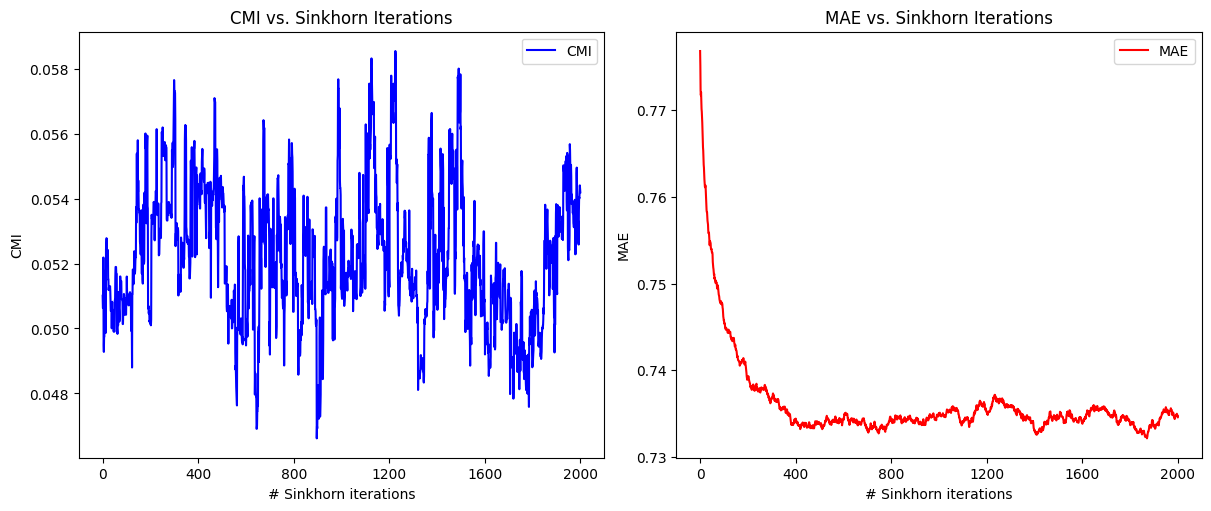

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (Replace with actual values)
npoints_cmi = len(cmi_loss_mnar30)  # Length of CMI data
npoints_mae = len(sk_maes30mnar)  # Length of MAE data

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# First graph (CMI)
axes[0].plot(np.linspace(0, 1, npoints_cmi) * npoints_cmi, cmi_loss_mnar30, label='CMI', color='b')
axes[0].set_xticks(np.linspace(0, npoints_cmi, 6))
axes[0].set_xlabel('# Sinkhorn iterations')
axes[0].set_ylabel('CMI')
axes[0].legend()
axes[0].set_title('CMI vs. Sinkhorn Iterations')

# Second graph (MAE)
axes[1].plot(np.linspace(0, 1, npoints_mae) * npoints_mae, sk_maes30mnar, label='MAE', color='r')
axes[1].set_xticks(np.linspace(0, npoints_mae, 6))
axes[1].set_xlabel('# Sinkhorn iterations')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_title('MAE vs. Sinkhorn Iterations')

# Show the combined plot
plt.show()
